In [23]:
# Marketing Mix Modeling using Linear Regression (includes saturation & carry over effects)

In [1]:
# Import data
import pandas as pd
data = pd.read_csv(
    'https://raw.githubusercontent.com/Garve/datasets/4576d323bf2b66c906d5130d686245ad205505cf/mmm.csv',
    parse_dates=['Date'],
    index_col='Date'
)
print(data)

                  TV    Radio  Banners     Sales
Date                                            
2018-01-07  13528.10     0.00     0.00   9779.80
2018-01-14      0.00  5349.65  2218.93  13245.19
2018-01-21      0.00  4235.86  2046.96  12022.66
2018-01-28      0.00  3562.21     0.00   8846.95
2018-02-04      0.00     0.00  2187.29   9797.07
...              ...      ...      ...       ...
2021-10-03      0.00     0.00  1691.68   9030.17
2021-10-10  11543.58  4615.35  2518.88  15904.11
2021-10-17      0.00  4556.16  1919.19  12839.29
2021-10-24      0.00     0.00  1707.65   9063.45
2021-10-31      0.00     0.00  1863.31   7250.21

[200 rows x 4 columns]


In [2]:
# Create function to apply saturation effects 
class ExponentialSaturation:
    def __init__(self, a=1.):
        self.a = a
        
    def transform(self, X):
        return 1 - np.exp(-self.a*X)

In [3]:
# Saturation function 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted, check_array

class ExponentialSaturation(BaseEstimator, TransformerMixin):
    def __init__(self, a=1.):
        self.a = a
        
    def fit(self, X, y=None):
        X = check_array(X)
        self._check_n_features(X, reset=True) # from BaseEstimator
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False) # from BaseEstimator
        return 1 - np.exp(-self.a*X)

In [4]:
# Create function to apply carryover effects
from scipy.signal import convolve2d
import numpy as np

class ExponentialCarryover(BaseEstimator, TransformerMixin):
    def __init__(self, strength=0.5, length=1):
        self.strength = strength
        self.length = length

    def fit(self, X, y=None):
        X = check_array(X)
        self._check_n_features(X, reset=True)
        self.sliding_window_ = (
            self.strength ** np.arange(self.length + 1)
        ).reshape(-1, 1)
        return self

    def transform(self, X: np.ndarray):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False)
        convolution = convolve2d(X, self.sliding_window_)
        if self.length > 0:
            convolution = convolution[: -self.length]
        return convolution

In [5]:
# Model building
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

adstock = ColumnTransformer(
    [
     #### TV block ####
     ('tv_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['TV']),
     ('radio_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['Radio']),
     ('banners_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['Banners']),
    ]
    #,remainder='passthrough'
)

model = Pipeline([
                  ('adstock', adstock),
                  ('regression', LinearRegression())
])

In [6]:
import pandas as pd
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

data = pd.read_csv(
    'https://raw.githubusercontent.com/Garve/datasets/4576d323bf2b66c906d5130d686245ad205505cf/mmm.csv',
    parse_dates=['Date'],
    index_col='Date'
)

#print(data)

X = data.drop(columns=['Sales'])
y = data['Sales']

model.fit(X, y)

print(cross_val_score(model, X, y, cv=TimeSeriesSplit()).mean())

0.5527190073236667


In [7]:
# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

tuned_model = RandomizedSearchCV(
    estimator=model,
    param_distributions={
        'adstock__tv_pipe__carryover__strength': uniform(0, 1),
        'adstock__tv_pipe__carryover__length': randint(0, 6),
        'adstock__tv_pipe__saturation__a': uniform(0, 0.01),
        'adstock__radio_pipe__carryover__strength': uniform(0, 1),
        'adstock__radio_pipe__carryover__length': randint(0, 6),
        'adstock__radio_pipe__saturation__a': uniform(0, 0.01),
        'adstock__banners_pipe__carryover__strength': uniform(0, 1),
        'adstock__banners_pipe__carryover__length': randint(0, 6),
        'adstock__banners_pipe__saturation__a': uniform(0, 0.01),
    },
    n_iter=1000,
    cv=TimeSeriesSplit(),
    random_state=0
)

In [8]:
# Check model performance
print(cross_val_score(tuned_model, X, y, cv=TimeSeriesSplit()))

[0.78018088 0.93446412 0.90499445 0.9554231  0.91318173]


In [9]:
tuned_model.fit(X, y)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('adstock',
                                              ColumnTransformer(transformers=[('tv_pipe',
                                                                               Pipeline(steps=[('carryover',
                                                                                                ExponentialCarryover()),
                                                                                               ('saturation',
                                                                                                ExponentialSaturation())]),
                                                                               ['TV']),
                                                                              ('radio_pipe',
                                                                               Pipeline(steps=[('carryover',
    

In [21]:
print("Model Outputs-------------------------------------------------------------------------\n")
print(tuned_model.best_params_)
print("\n")
print("Regression Coefficients -------------------------------------------------------------------------\n")
print(tuned_model.best_estimator_.named_steps['regression'].coef_)
print("\n")
print("Regression Intercept -------------------------------------------------------------------------")
print(tuned_model.best_estimator_.named_steps['regression'].intercept_)

Model Outputs-------------------------------------------------------------------------

{'adstock__banners_pipe__carryover__length': 0, 'adstock__banners_pipe__carryover__strength': 0.8751433768323792, 'adstock__banners_pipe__saturation__a': 0.0065945872672305865, 'adstock__radio_pipe__carryover__length': 0, 'adstock__radio_pipe__carryover__strength': 0.47826450020005506, 'adstock__radio_pipe__saturation__a': 0.005530533233767334, 'adstock__tv_pipe__carryover__length': 4, 'adstock__tv_pipe__carryover__strength': 0.4465948502605501, 'adstock__tv_pipe__saturation__a': 5.4866952650955984e-05}


Regression Coefficients -------------------------------------------------------------------------

[10225.65124621  2402.6630737   2453.7368643 ]


Regression Intercept -------------------------------------------------------------------------
5457.335803250535


In [12]:
# Predict model
X_new = pd.DataFrame({
    'TV': [10000, 0, 0],
    'Radio': [0, 3000, 0],
    'Banners': [1000, 1000, 1000]
})

tuned_model.predict(X_new)

array([12225.82566253, 12532.63109588,  8967.66170481])

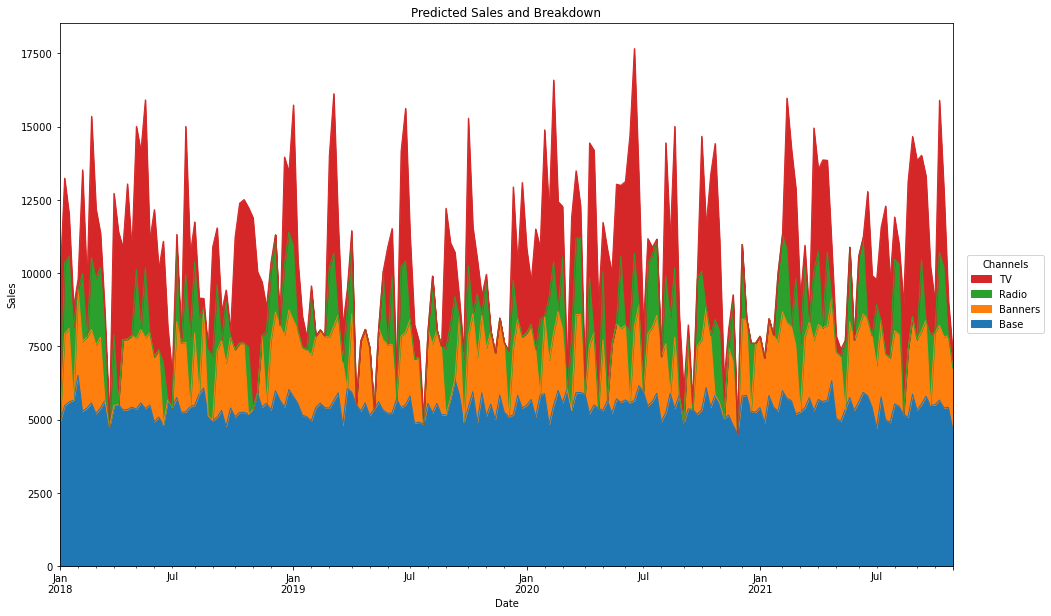

In [13]:
# Plotting the sales contributions of each channel
adstock_data = pd.DataFrame(
    tuned_model.best_estimator_.named_steps['adstock'].transform(X),
    columns=X.columns,
    index=X.index
)

weights = pd.Series(
    tuned_model.best_estimator_.named_steps['regression'].coef_,
    index=X.columns
)

base = tuned_model.best_estimator_.named_steps['regression'].intercept_

unadj_contributions = adstock_data.mul(weights).assign(Base=base)
adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y, axis=0)
                    )

ax = (adj_contributions[['Base', 'Banners', 'Radio', 'TV']]
      .plot.area(
          figsize=(16, 10),
          linewidth=1,
          title='Predicted Sales and Breakdown',
          ylabel='Sales',
          xlabel='Date'
      )
     )
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1],
    title='Channels', loc="center left",
    bbox_to_anchor=(1.01, 0.5)
)